# Task One -- Sentiment Analysis (FiQA SA)

## Importing Packages

In [1]:
from datasets import load_dataset # Doesn't work on PyCharm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import reprlib

from gensim.models import LdaModel
from gensim.matutils import any2sparse
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

import numpy as np
import matplotlib.pyplot as plt
import json

ModuleNotFoundError: No module named 'datasets'

## Importing the Training Files

In [33]:
train_files = ["data_cache/FiQA_ABSA_task1/task1_headline_ABSA_train.json",
               "data_cache/FiQA_ABSA_task1/task1_post_ABSA_train.json"]

In [34]:
def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, "r", encoding="utf-8") as handle:  # UTF-8 is needed to prevent a UnicodeDecodeError I recieved
            dataf = json.load(handle)

        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        # print(len(dataf_text))
        train_text.extend(dataf_text)

        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        # print(len(dataf_labels))
        train_labels.extend(dataf_labels)

    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f"Number of instances: {len(all_text)}")
print(f"Number of labels: {len(all_labels)}")

all_labels = threshold_scores(all_labels)
print(f"Number of negative labels: {np.sum(all_labels==0)}")
print(f"Number of neutral labels: {np.sum(all_labels==1)}")
print(f"Number of positive labels: {np.sum(all_labels==2)}")

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


## Creating the Test Split

In [35]:
# Split test data from training data
train_documents, test_documents, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels)  # make sure the same proportion of labels is in the test set and training set

# Split validation data from training data
train_documents, val_documents, train_labels, val_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.15, 
    stratify=train_labels)  # make sure the same proportion of labels is in the test set and training set

print(f"Number of training instances = {len(train_documents)}")
print(f"Number of validation instances = {len(val_documents)}")
print(f"Number of test instances = {len(test_documents)}")

print(f"\nWhat does one instance look like from the training set?:\n{train_documents[234]}")
print(f"...and here is its corresponding sentiment label: {train_labels[234]}")

Number of training instances = 754
Number of validation instances = 134
Number of test instances = 223

What does one instance look like from the training set?:
Barclays appoints JPMorgan's Paul Compton as new COO
...and here is its corresponding sentiment label: 1


## Preprocessing the Data

### Tokenizing, Stop Word Removal, Case Folding, and Lemmatisation

In [36]:
# import nltk
# nltk.download('omw-1.4')
# nltk.download('stopwords')

In [37]:
# Define the stop words
stopwords_list = stopwords.words("english")

class LemmaTokenizer(object):
    def __call__(self, documents):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(documents)]
    
vectorizer_Lem = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')

vectorizer_Lem.fit(train_documents)  # Learn the vocabulary
X_train_Lem = vectorizer_Lem.transform(train_documents) # extract training set bags of words
X_val_Lem = vectorizer_Lem.transform(val_documents) # extract validation set bags of words
X_test_Lem = vectorizer_Lem.transform(test_documents)  # extract test set bags of words

C:\Users\misha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\misha\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [38]:
vocabulary_Lem = vectorizer_Lem.vocabulary_
print(f"Vocabulary size = {len(vocabulary_Lem)}")

Vocabulary size = 2953


### Tokenizing, Stop Word Removal, Case Folding, and no Lemmatisation

In [39]:
# Define the stop words
stopwords_list = stopwords.words("english")

class Tokenizer(object):
    def __call__(self, documents):
        return word_tokenize(documents.lower())

vectorizer = CountVectorizer(tokenizer=Tokenizer(), stop_words='english')

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents) # extract training set bags of words
X_val = vectorizer.transform(val_documents) # extract validation set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

## Applying Naive Bayes to Lem set

In [40]:
# Defining the classifier
classifier_Lem = MultinomialNB()

# Training the classifier
classifier_Lem.fit(X_train_Lem, train_labels)

MultinomialNB()

In [41]:
# Testing the classifier
y_val_pred_Lem = classifier_Lem.predict(X_test_Lem)

In [42]:
acc_lem = accuracy_score(test_labels, y_val_pred_Lem)
print(f'Accuracy = {acc_lem}')

prec_lem = precision_score(test_labels, y_val_pred_Lem, average='macro')
print(f'Precision (macro average) = {prec_lem}')

rec_lem = recall_score(test_labels, y_val_pred_Lem, average='macro')
print(f'Recall (macro average) = {rec_lem}')

f1_micro_lem = f1_score(test_labels, y_val_pred_Lem, average='micro')
print(f'F1 score (micro average) = {f1_micro_lem}')

f1_macro_lem = f1_score(test_labels, y_val_pred_Lem, average='macro')
print(f'F1 score (macro average) = {f1_macro_lem}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_labels, y_val_pred_Lem))

Accuracy = 0.672645739910314
Precision (macro average) = 0.6912606127722407
Recall (macro average) = 0.5362038807305862
F1 score (micro average) = 0.672645739910314
F1 score (macro average) = 0.5551949515438359
              precision    recall  f1-score   support

           0       0.65      0.45      0.53        62
           1       0.75      0.23      0.35        39
           2       0.67      0.93      0.78       122

    accuracy                           0.67       223
   macro avg       0.69      0.54      0.56       223
weighted avg       0.68      0.67      0.64       223



## Applying Naive Bayes to non Lem set

In [43]:
# Defining the classifier
classifier = MultinomialNB()

# Training the classifier
classifier.fit(X_train, train_labels)

MultinomialNB()

In [44]:
# Testing the classifier
y_val_pred = classifier.predict(X_test)

In [45]:
acc = accuracy_score(test_labels, y_val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(test_labels, y_val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_labels, y_val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1_micro = f1_score(test_labels, y_val_pred, average='micro')
print(f'F1 score (micro average) = {f1_micro}')

f1_macro = f1_score(test_labels, y_val_pred, average='macro')
print(f'F1 score (macro average) = {f1_macro}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_labels, y_val_pred))

Accuracy = 0.6547085201793722
Precision (macro average) = 0.6726178190574474
Recall (macro average) = 0.5263280406062003
F1 score (micro average) = 0.6547085201793722
F1 score (macro average) = 0.549227126670049
              precision    recall  f1-score   support

           0       0.63      0.39      0.48        62
           1       0.73      0.28      0.41        39
           2       0.65      0.91      0.76       122

    accuracy                           0.65       223
   macro avg       0.67      0.53      0.55       223
weighted avg       0.66      0.65      0.62       223



## Applying Logistic Regression to Lem set

In [46]:
# Defining the classifier
logi_classifier_Lem = LogisticRegression()

# Training the classifier
logi_classifier_Lem.fit(X_train_Lem, train_labels)

LogisticRegression()

In [47]:
# Testing the classifier
y_val_pred_logi_Lem = logi_classifier_Lem.predict(X_test_Lem)

In [48]:
acc_logi_lem = accuracy_score(test_labels, y_val_pred_logi_Lem)
print(f'Accuracy = {acc_logi_lem}')

prec_logi_lem = precision_score(test_labels, y_val_pred_logi_Lem, average='macro')
print(f'Precision (macro average) = {prec_logi_lem}')

rec_logi_lem = recall_score(test_labels, y_val_pred_logi_Lem, average='macro')
print(f'Recall (macro average) = {rec_logi_lem}')

f1_micro_logi_lem = f1_score(test_labels, y_val_pred_logi_Lem, average='micro')
print(f'F1 score (micro average) = {f1_micro_logi_lem}')

f1_macro_logi_lem = f1_score(test_labels, y_val_pred_logi_Lem, average='macro')
print(f'F1 score (macro average) = {f1_macro_logi_lem}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_labels, y_val_pred_logi_Lem))

Accuracy = 0.672645739910314
Precision (macro average) = 0.6430648692598058
Recall (macro average) = 0.5525950634358884
F1 score (micro average) = 0.672645739910314
F1 score (macro average) = 0.5693043273688435
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        62
           1       0.59      0.26      0.36        39
           2       0.69      0.89      0.77       122

    accuracy                           0.67       223
   macro avg       0.64      0.55      0.57       223
weighted avg       0.66      0.67      0.65       223



## Applying Logistic Regression to non Lem set

In [49]:
# Defining the classifier
logi_classifier = LogisticRegression()

# Training the classifier
logi_classifier.fit(X_train, train_labels)

LogisticRegression()

In [50]:
# Testing the classifier
y_val_pred_logi = logi_classifier.predict(X_test)

In [51]:
acc_logi = accuracy_score(test_labels, y_val_pred_logi)
print(f'Accuracy = {acc_logi}')

prec_logi = precision_score(test_labels, y_val_pred_logi, average='macro')
print(f'Precision (macro average) = {prec_logi}')

rec_logi = recall_score(test_labels, y_val_pred_logi, average='macro')
print(f'Recall (macro average) = {rec_logi}')

f1_micro_logi = f1_score(test_labels, y_val_pred_logi, average='micro')
print(f'F1 score (micro average) = {f1_micro_logi}')

f1_macro_logi = f1_score(test_labels, y_val_pred_logi, average='macro')
print(f'F1 score (macro average) = {f1_macro_logi}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_labels, y_val_pred_logi))

Accuracy = 0.6591928251121076
Precision (macro average) = 0.6231460532931121
Recall (macro average) = 0.5385835740145629
F1 score (micro average) = 0.6591928251121076
F1 score (macro average) = 0.5520781122487368
              precision    recall  f1-score   support

           0       0.63      0.52      0.57        62
           1       0.56      0.23      0.33        39
           2       0.68      0.87      0.76       122

    accuracy                           0.66       223
   macro avg       0.62      0.54      0.55       223
weighted avg       0.64      0.66      0.63       223



## Comparing Lem to Non Lem

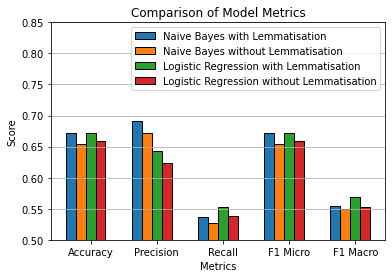

In [52]:
# define the different metrics and their scores for bayes with lem
metrics = ["Accuracy", "Precision", "Recall", "F1 Micro", "F1 Macro"]
bayes_lem = [acc_lem, prec_lem, rec_lem, f1_micro_lem, f1_macro_lem]

# define their scores for Bayes non lem
bayes_non_lem = [acc, prec, rec, f1_micro, f1_macro]

# Logistic Regresion with Lemmatisation
logi_lem = [acc_logi_lem, prec_logi_lem, rec_logi_lem, f1_micro_logi_lem, f1_macro_logi_lem]

# Logistic Regresion sans Lemmatisation
logi = [acc_logi, prec_logi, rec_logi, f1_micro_logi, f1_macro_logi]

# set the width of the bars
bar_width = 0.15

# set the x-positions of the bars
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# create the bar plot
plt.bar(r1, bayes_lem, color="tab:blue", width=bar_width, edgecolor="black", label="Naive Bayes with Lemmatisation")
plt.bar(r2, bayes_non_lem, color="tab:orange", width=bar_width, edgecolor="black", label="Naive Bayes without Lemmatisation")
plt.bar(r3, logi_lem, color="tab:green", width=bar_width, edgecolor="black", label="Logistic Regression with Lemmatisation")
plt.bar(r4, logi, color="tab:red", width=bar_width, edgecolor="black", label="Logistic Regression without Lemmatisation")

# add labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.xticks([r + bar_width*2 for r in range(len(metrics))], metrics)
plt.title("Comparison of Model Metrics")

# set y-axis limits
plt.ylim(0.5, 0.85)

# add legend
plt.legend()

# show the plot
plt.grid(axis="y")
plt.savefig("model_comparison.png", dpi=300)
plt.show()

## Identifying Common Themes/Topics associated with Positive/Negative Sentiment using LDA

In [75]:
# create training dictionary
train_documents_tok = [LemmaTokenizer()(doc) for doc in train_documents]
train_dictionary = Dictionary(train_documents_tok)

# create testing dictionary
test_documents_tok = [LemmaTokenizer()(doc) for doc in test_documents]
test_dictionary = Dictionary(test_documents_tok)

# create bag of words
train_corpus = [train_dictionary.doc2bow(doc) for doc in train_documents_tok]
test_corpus = [test_dictionary.doc2bow(doc) for doc in test_documents_tok]

In [76]:
# Classify the documents using the trained Naive Bayes classifier
# y_val_pred_Lem = classifier_Lem.predict(X_test_Lem)

# make predictions using the trained Naive Bayes model
train_predictions = classifier_Lem.predict(X_train_Lem)
test_predictions = classifier_Lem.predict(X_test_Lem)

In [99]:
# Get the index for each sentiment, so the LDA method can be trained to identify topics on positive data etc
positive_train_docs = []
neutral_train_docs = []
negative_train_docs = []

for i, val in enumerate(train_predictions):
    if val == 2:
        positive_train_docs.append(i)
    elif val == 1:
        neutral_train_docs.append(i)
    elif val == 0:
        negative_train_docs.append(i)
        
positive_test_docs = []
neutral_test_docs = []
negative_test_docs = []

for i, val in enumerate(test_predictions):
    if val == 2:
        positive_test_docs.append(i)
    elif val == 1:
        neutral_test_docs.append(i)
    elif val == 0:
        negative_test_docs.append(i)

In [130]:
# Defining the positive corpuses
positive_train_corpus = [train_dictionary.doc2bow(train_documents_tok[i]) for i in positive_train_docs]
positive_test_corpus = [test_dictionary.doc2bow(test_documents_tok[i]) for i in positive_test_docs]

# Defining the negative corpuses
negative_train_corpus = [train_dictionary.doc2bow(train_documents_tok[i]) for i in negative_train_docs]
negative_test_corpus = [test_dictionary.doc2bow(test_documents_tok[i]) for i in negative_test_docs]

# train LDA model for the positive corpus
num_topics = 20 # number of topics to extract
positive_lda_model = LdaModel(corpus=positive_train_corpus, num_topics=num_topics, id2word=train_dictionary, iterations=50, passes=20)

# train LDA model for the negative corpus
negative_lda_model = LdaModel(corpus=negative_train_corpus, num_topics=num_topics, id2word=train_dictionary, iterations=50, passes=20)

In [131]:
for idx, topic in positive_lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.036*"$" + 0.029*"on" + 0.021*"." + 0.015*"a" + 0.013*"for" + 0.011*"," + 0.010*"day" + 0.010*"'s" + 0.009*"fda" + 0.009*"cancer"


Topic: 1 
Words: 0.033*"to" + 0.021*"$" + 0.012*"in" + 0.010*"with" + 0.008*"a" + 0.007*"lse" + 0.007*"share" + 0.007*"plc" + 0.007*"price" + 0.007*"bg"


Topic: 2 
Words: 0.057*"." + 0.041*"$" + 0.025*"a" + 0.015*"it" + 0.013*"of" + 0.011*"-" + 0.011*"at" + 0.011*"aapl" + 0.009*":" + 0.009*"be"


Topic: 3 
Words: 0.036*"$" + 0.024*"." + 0.021*"to" + 0.018*":" + 0.016*"in" + 0.015*"the" + 0.014*"http" + 0.014*"@" + 0.010*"stake" + 0.010*"and"


Topic: 4 
Words: 0.028*"inbev" + 0.027*"$" + 0.027*"sabmiller" + 0.025*"ab" + 0.017*"," + 0.013*":" + 0.011*"to" + 0.010*"for" + 0.008*"bp" + 0.008*"..."


Topic: 5 
Words: 0.034*"$" + 0.025*"." + 0.022*"to" + 0.016*"the" + 0.013*"up" + 0.012*"a" + 0.011*"after" + 0.011*"for" + 0.009*"i" + 0.009*"long"


Topic: 6 
Words: 0.036*"$" + 0.016*"for" + 0.011*"to" + 0.011*"from" + 0.011*":" + 0.011*"and" 

In [132]:
for idx, topic in negative_lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.017*"$" + 0.013*"fall" + 0.013*"in" + 0.009*"?" + 0.009*"." + 0.009*"a" + 0.005*"of" + 0.005*"share" + 0.005*"to" + 0.005*"ready"


Topic: 1 
Words: 0.019*"on" + 0.015*"price" + 0.014*"$" + 0.011*"lower" + 0.011*"..." + 0.008*"," + 0.008*"'s" + 0.008*"." + 0.008*"drop" + 0.008*"hit"


Topic: 2 
Words: 0.014*"," + 0.014*":" + 0.011*"$" + 0.009*"a" + 0.009*"http" + 0.009*"dma" + 0.009*"support" + 0.006*"spy" + 0.005*"to" + 0.005*"@"


Topic: 3 
Words: 0.009*"ntap" + 0.009*"market" + 0.009*"think" + 0.009*"price" + 0.009*"cut" + 0.008*"@" + 0.008*"will" + 0.007*"." + 0.006*"," + 0.006*"$"


Topic: 4 
Words: 0.027*"," + 0.023*"$" + 0.017*"the" + 0.013*"to" + 0.010*"%" + 0.010*"is" + 0.007*"." + 0.007*"..." + 0.007*"only" + 0.007*"weak"


Topic: 5 
Words: 0.021*"$" + 0.019*"on" + 0.017*":" + 0.011*"http" + 0.008*"%" + 0.008*"down" + 0.008*"a" + 0.008*"juniper" + 0.008*"csco" + 0.008*"q1"


Topic: 6 
Words: 0.048*"$" + 0.028*"." + 0.020*":" + 0.017*"short" + 0.017*"to" + 0

In [117]:
# Testing on unseen positive data    
print(test_documents_tok[positive_test_docs[0]])

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
positive_bow_vector = test_dictionary.doc2bow(test_documents_tok[positive_test_docs[0]])

for idx, count in positive_bow_vector:
    print(f'{test_dictionary[idx]}: {count}')

['$', 'aapl', 'long', '630.91']
$: 1
630.91: 1
aapl: 1
long: 1


In [118]:
# Testing on unseen negative data    
print(test_documents_tok[negative_test_docs[0]])

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
negative_bow_vector = test_dictionary.doc2bow(test_documents_tok[negative_test_docs[0]])

for idx, count in negative_bow_vector:
    print(f'{test_dictionary[idx]}: {count}')

['$', 'fb', 'i', 'guess', 'they', 'want', 'it', 'down', 'look', 'at', 'the', 'those', 'sell', 'order']
$: 1
down: 1
fb: 1
the: 1
at: 1
guess: 1
i: 1
it: 1
look: 1
order: 1
sell: 1
they: 1
those: 1
want: 1
